# Flatland Javascript Renderer

This is in active development and is intended to replace the tkinter / PIL renderer.
This notebook shows how the JS renderer can be started in a notebook using an "iframe".  It starts a Flask server in a background thread, listening on port 8080, localhost.

In [1]:
import time
import os
import numpy as np 
from numpy import array
import threading
import webbrowser
import pandas as pd # useful for displaying tables
import ipysheet as ips
from IPython.display import HTML, display
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
#pd.describe_option("rows")

In Flatland you can use custom observation builders and predicitors<br>
Observation builders generate the observation needed by the controller<br>
Preditctors can be used to do short time prediction which can help in avoiding conflicts in the network

In [4]:
from flatland.envs.malfunction_generators import malfunction_from_params, MalfunctionParameters
from flatland.envs.observations import GlobalObsForRailEnv
# First of all we import the Flatland rail environment
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_env import RailEnvActions
from flatland.envs.rail_generators import sparse_rail_generator
from flatland.envs.schedule_generators import sparse_schedule_generator
# We also include a renderer because we want to visualize what is going on in the environment
from flatland.utils.rendertools import RenderTool, AgentRenderVariant
from flatland.utils.flask_util import simple_flask_server

Flask static folder:  /home/jeremy/projects/aicrowd/rl-trains/flatland/notebooks/static


This is an introduction example for the Flatland 2.1.* version.<br>
Changes and highlights of this version include<br>
- Stochastic events (malfunctions)<br>
- Different travel speeds for differet agents<br>
- Levels are generated using a novel generator to reflect more realistic railway networks<br>
- Agents start outside of the environment and enter at their own time<br>
- Agents leave the environment after they have reached their goal<br>
Use the new sparse_rail_generator to generate feasible network configurations with corresponding tasks<br>
Training on simple small tasks is the best way to get familiar with the environment<br>
We start by importing the necessary rail and schedule generators<br>
The rail generator will generate the railway infrastructure<br>
The schedule generator will assign tasks to all the agent within the railway network

The railway infrastructure can be build using any of the provided generators in env/rail_generators.py<br>
Here we use the sparse_rail_generator with the following parameters

In [5]:
nSize = 3

if nSize == 1: 
    width = 30  # With of map
    height = 30  # Height of map
    nr_trains = 5  # Number of trains that have an assigned task in the env
    cities_in_map = 2  # Number of cities where agents can start or end
elif nSize == 2:
    width = 8 * 7  # With of map
    height = 8 * 7  # Height of map
    nr_trains = 20  # Number of trains that have an assigned task in the env
    cities_in_map = 10  # Number of cities where agents can start or end
else:
    width = 16 * 7  # With of map
    height = 9 * 7  # Height of map
    nr_trains = 50  # Number of trains that have an assigned task in the env
    cities_in_map = 20  # Number of cities where agents can start or end
    
seed = 14  # Random seed
grid_distribution_of_cities = False  # Type of city distribution, if False cities are randomly placed
max_rails_between_cities = 2  # Max number of tracks allowed between cities. This is number of entry point to a city
max_rail_in_cities = 6  # Max number of parallel tracks within a city, representing a realistic trainstation

In [6]:
generator_configs = [
    [30, 30, 5, 2],
    [8*7, 8*7, 20, 10],
    [16*7, 9*7, 50, 20],
]
dfConfig = pd.DataFrame(generator_configs, columns="width height nr_trains cities_in_map".split(" "))
dfConfig.index.name="config"
sheet = ips.from_dataframe(dfConfig.T)
sheet.column_resizing = True
sheet.column_width = [ 30, 30, 30 ]
sheet.stretch_headers = "none"
#sheet.rowHeaderWidth=200  # doesn't work

display(HTML("Here are the configuration options in an editable mini spreadsheet:"))
display(sheet)

Sheet(cells=(Cell(choice=[], column_end=0, column_start=0, numeric_format='0[.]0', row_start=0, squeeze_row=Fa…

In [23]:
n_config_column = 2
srConf = dfConfig.iloc[n_config_column,:]
srConf.width, srConf.height

(112, 63)

In [26]:
dfConf = ips.to_dataframe(sheet)
srConf = dfConf.iloc[:,n_config_column]
srConf

width            112
height            63
nr_trains         50
cities_in_map     20
Name: 2, dtype: int64

In [27]:
rail_generator = sparse_rail_generator(max_num_cities=cities_in_map,
                                       seed=seed,
                                       grid_mode=grid_distribution_of_cities,
                                       max_rails_between_cities=max_rails_between_cities,
                                       max_rails_in_city=max_rail_in_cities,
                                       )

The schedule generator can make very basic schedules with a start point, end point and a speed profile for each agent.<br>
The speed profiles can be adjusted directly as well as shown later on. We start by introducing a statistical<br>
distribution of speed profiles

Different agent types (trains) with different speeds.

In [28]:
speed_ration_map = {1.: 0.25,  # Fast passenger train
                    1. / 2.: 0.25,  # Fast freight train
                    1. / 3.: 0.25,  # Slow commuter train
                    1. / 4.: 0.25}  # Slow freight train

We can now initiate the schedule generator with the given speed profiles

In [29]:
schedule_generator = sparse_schedule_generator(speed_ration_map)

We can furthermore pass stochastic data to the RailEnv constructor which will allow for stochastic malfunctions<br>
during an episode.

In [30]:
stochastic_data = MalfunctionParameters(malfunction_rate=10000,  # Rate of malfunction occurence
                                        min_duration=15,  # Minimal duration of malfunction
                                        max_duration=50  # Max duration of malfunction
                                        )
# Custom observation builder without predictor
observation_builder = GlobalObsForRailEnv()

Custom observation builder with predictor, uncomment line below if you want to try this one<br>
observation_builder = TreeObsForRailEnv(max_depth=2, predictor=ShortestPathPredictorForRailEnv())

Construct the enviornment with the given observation, generataors, predictors, and stochastic data

In [31]:
env = RailEnv(width=srConf.width,
              height=srConf.height,
              rail_generator=rail_generator,
              schedule_generator=schedule_generator,
              number_of_agents=srConf.nr_trains,
              obs_builder_object=observation_builder,
              malfunction_generator_and_process_data=malfunction_from_params(stochastic_data),
              remove_agents_at_target=True)
env.reset()
pass

Initiate the renderer

In [32]:
env_renderer = RenderTool(env, # gl="PILSVG", # defaults to BROWSER
                          agent_render_variant=AgentRenderVariant.ONE_STEP_BEHIND,
                          show_debug=False,
                          screen_height=600,  # Adjust these parameters to fit your resolution
                          screen_width=800)  # Adjust these parameters to fit your resolution

render_pil = RenderTool(env, gl="PILSVG",
                          agent_render_variant=AgentRenderVariant.ONE_STEP_BEHIND,
                          show_debug=False,
                          screen_height=600,  # Adjust these parameters to fit your resolution
                          screen_width=800)  # Adjust these parameters to fit your resolution



WebSocket transport not available. Install eventlet or gevent and gevent-websocket for improved performance.


 * Serving Flask app "flatland.utils.flask_util" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8083/ (Press CTRL+C to quit)


The first thing we notice is that some agents don't have feasible paths to their target.<br>
We first look at the map we have created

nv_renderer.render_env(show=True)<br>
time.sleep(2)<br>
Import your own Agent or use RLlib to train agents on Flatland<br>
As an example we use a random agent instead

In [33]:
class RandomAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
    def act(self, state):
        """
        :param state: input is the observation of the agent
        :return: returns an action
        """
        return np.random.choice([RailEnvActions.MOVE_FORWARD, RailEnvActions.MOVE_RIGHT, RailEnvActions.MOVE_LEFT,
                                 RailEnvActions.STOP_MOVING])
    def step(self, memories):
        """
        Step function to improve agent by adjusting policy given the observations
        :param memories: SARS Tuple to be
        :return:
        """
        return
    def save(self, filename):
        # Store the current policy
        return
    def load(self, filename):
        # Load a policy
        return

Initialize the agent with the parameters corresponding to the environment and observation_builder

In [34]:
controller = RandomAgent(218, env.action_space[0])

We start by looking at the information of each agent<br>
We can see the task assigned to the agent by looking at

In [35]:

dfAgents = pd.DataFrame(
    [ (agent_idx, agent.initial_position, agent.direction, agent.target)
     for agent_idx, agent in enumerate(env.agents) 
    ],
    columns="idx,initial_pos,direction,target".split(",")
)
  

display(HTML("<h2>Agents in the environment have to solve the following tasks:</h2>"))
pd.set_option("display.max_rows", 10)
display(dfAgents)

,idx,initial_pos,direction,target
0,0,"(22, 74)",2,"(19, 93)"
1,1,"(7, 12)",0,"(44, 16)"
2,2,"(19, 92)",2,"(21, 9)"
3,3,"(42, 71)",3,"(18, 52)"
4,4,"(39, 16)",3,"(19, 95)"
...,...,...,...,...
45,45,"(37, 57)",1,"(45, 102)"
46,46,"(43, 16)",1,"(6, 94)"
47,47,"(56, 26)",0,"(18, 52)"
48,48,"(41, 16)",3,"(32, 89)"


The agent will always have a status indicating if it is currently present in the environment or done or active<br>
For example we see that agent with index 0 is currently not active

In [36]:
print("\n Their current statuses are:")
print("============================")


 Their current statuses are:


In [37]:
dfAgStatus = pd.DataFrame(
    [
        (str(agent.status), str(agent.position))
        for agent_idx, agent in enumerate(env.agents)
    ], columns=["Status", "CurPosn"])
display(dfAgStatus)
# print("Agent {} status is: {} with its current position being {}".format(agent_idx, str(agent.status),
#str(agent.position)))

,Status,CurPosn
0,RailAgentStatus.READY_TO_DEPART,None
1,RailAgentStatus.READY_TO_DEPART,None
2,RailAgentStatus.READY_TO_DEPART,None
3,RailAgentStatus.READY_TO_DEPART,None
4,RailAgentStatus.READY_TO_DEPART,None
...,...,...
45,RailAgentStatus.READY_TO_DEPART,None
46,RailAgentStatus.READY_TO_DEPART,None
47,RailAgentStatus.READY_TO_DEPART,None
48,RailAgentStatus.READY_TO_DEPART,None


The agent needs to take any action [1,2,3] except do_nothing or stop to enter the level<br>
If the starting cell is free they will enter the level<br>
If multiple agents want to enter the same cell at the same time the lower index agent will enter first.

Let's check if there are any agents with the same start location

In [38]:
agents_with_same_start = set()
agent_pairs = []
dict_pos_agents = {}

for iAgent, agent in enumerate(env.agents):
    rcPos = agent.initial_position
    if rcPos in dict_pos_agents:
        dict_pos_agents[rcPos].append(iAgent)
    else:
        dict_pos_agents[rcPos] = [iAgent]

dict_pos_agents

{(22, 74): [0, 34],
 (7, 12): [1],
 (19, 92): [2, 24],
 (42, 71): [3],
 (39, 16): [4, 14, 37],
 (32, 90): [5],
 (6, 93): [6, 41],
 (41, 29): [7, 40, 49],
 (50, 44): [8, 25, 44],
 (48, 44): [9],
 (41, 16): [10, 28, 38, 48],
 (19, 96): [11, 18],
 (32, 86): [12, 17, 27],
 (53, 63): [13, 29],
 (56, 26): [15, 42, 47],
 (19, 24): [16],
 (37, 57): [19, 35, 45],
 (51, 86): [20, 43],
 (42, 102): [21],
 (39, 29): [22],
 (43, 16): [23, 32, 46],
 (24, 36): [26],
 (9, 74): [30],
 (24, 38): [31, 36],
 (21, 12): [33],
 (19, 94): [39]}

Text(0.5, 1.0, 'Agent Indices at initial positions')

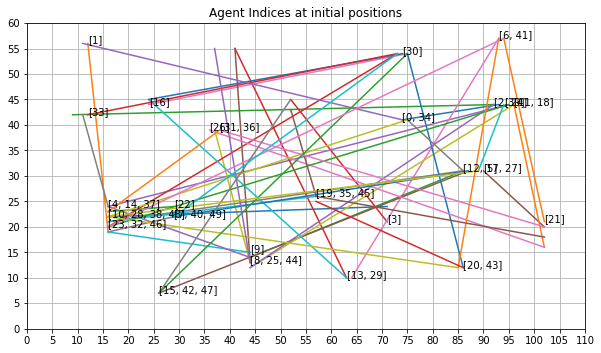

In [68]:
r_aspect = srConf.width / srConf.height
plt.figure(figsize=(10, 10 / r_aspect))
iRev = [1, 0]
rc2xy = array([[0,1],[-1,0]]).T
for agent in env.agents:
    rc1 = array(agent.initial_position)
    rc2 = array(agent.target)
    #plt.arrow(*rc1[iRev], *(rc2 - rc1)[iRev], width=0.5 )
    rc12 = np.stack([rc1, rc2])
    xy12 = np.matmul(rc12, rc2xy)
    plt.plot(xy12[:,0], srConf.height + xy12[:,1])
    #plt.arrow(*rc1[iRev], *(rc2 - rc1)[iRev], width=0.1, head_width=1 )

for rcStart, liAgent in dict_pos_agents.items():
    xyStart = np.matmul(array(rcStart), rc2xy) + [0,srConf.height]
    plt.annotate(liAgent, xyStart)
    
#plt.xlim(0,srConf.width)
#plt.ylim(0,srConf.height)
plt.xticks(range(0,srConf.width, 5))
plt.yticks(range(0,srConf.height, 5))
plt.grid()
plt.title("Agent Indices at initial positions")

/home/jeremy/projects/aicrowd/rl-trains/flatland/flatland/utils/rendertools.py:412: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  Observation builder needs to populate: env.dev_obs_dict")


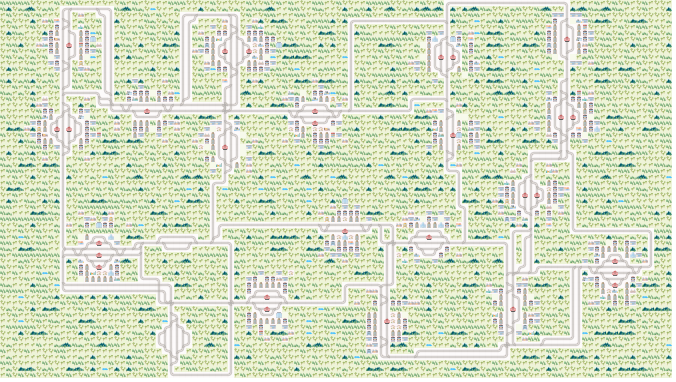

In [69]:
import PIL
render_pil.render_env()
PIL.Image.fromarray(render_pil.get_image())

In [135]:
if agent.initial_position in dict_count:
    print(dict_count[agent.initial_position])

30


TypeError: object of type 'int' has no len()

In [87]:
print(*rc1, *rc2)

7 19 9 6


(0, 63)

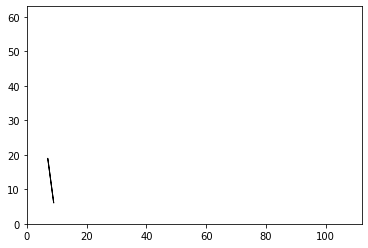

In [97]:
plt.arrow(*rc1, *(rc2 - rc1))


In [79]:
dict_count

{(10, 6): 56,
 (8, 6): 90,
 (5, 19): 90,
 (24, 23): 12,
 (7, 19): 30,
 (22, 23): 30,
 (20, 10): 6,
 (24, 10): 2}

In [81]:
env.agents[0]

EnvAgent(initial_position=(10, 6), initial_direction=1, direction=1, target=(8, 19), moving=False, speed_data={'position_fraction': 0.0, 'speed': 1.0, 'transition_action_on_cellexit': 0.0}, malfunction_data={'malfunction': 0, 'malfunction_rate': 0.0, 'next_malfunction': 0, 'nr_malfunctions': 0, 'moving_before_malfunction': False}, handle=0, status=<RailAgentStatus.READY_TO_DEPART: 0>, position=None, old_direction=None, old_position=None)

In [82]:
env.agents[1]

EnvAgent(initial_position=(10, 6), initial_direction=1, direction=1, target=(23, 10), moving=False, speed_data={'position_fraction': 0.0, 'speed': 0.5, 'transition_action_on_cellexit': 0.0}, malfunction_data={'malfunction': 0, 'malfunction_rate': 0.0, 'next_malfunction': 0, 'nr_malfunctions': 0, 'moving_before_malfunction': False}, handle=1, status=<RailAgentStatus.READY_TO_DEPART: 0>, position=None, old_direction=None, old_position=None)

Lets try to enter with all of these agents at the same time

In [17]:
action_dict = dict()

In [18]:
for agent_id in agents_with_same_start:
    action_dict[agent_id] = 1  # Try to move with the agents

Do a step in the environment to see what agents entered:

In [19]:
env.step(action_dict)
pass

Current state and position of the agents after all agents with same start position tried to move

In [20]:
print("\n This happened when all tried to enter at the same time:")
print("========================================================")
for agent_id in agents_with_same_start:
    print(
        "Agent {} status is: {} with the current position being {}.".format(
            agent_id, str(env.agents[agent_id].status),
            str(env.agents[agent_id].position)))


 This happened when all tried to enter at the same time:
Agent 0 status is: RailAgentStatus.ACTIVE with the current position being (22, 74).
Agent 2 status is: RailAgentStatus.ACTIVE with the current position being (19, 92).
Agent 4 status is: RailAgentStatus.ACTIVE with the current position being (39, 16).
Agent 6 status is: RailAgentStatus.ACTIVE with the current position being (6, 93).
Agent 7 status is: RailAgentStatus.ACTIVE with the current position being (41, 29).
Agent 8 status is: RailAgentStatus.ACTIVE with the current position being (50, 44).
Agent 10 status is: RailAgentStatus.ACTIVE with the current position being (41, 16).
Agent 11 status is: RailAgentStatus.ACTIVE with the current position being (19, 96).
Agent 12 status is: RailAgentStatus.ACTIVE with the current position being (32, 86).
Agent 13 status is: RailAgentStatus.ACTIVE with the current position being (53, 63).
Agent 14 status is: RailAgentStatus.READY_TO_DEPART with the current position being None.
Agent 15 

As you see only the agents with lower indexes moved. As soon as the cell is free again the agents can attempt<br>
to start again.

You will also notice, that the agents move at different speeds once they are on the rail.<br>
The agents will always move at full speed when moving, never a speed inbetween.<br>
The fastest an agent can go is 1, meaning that it moves to the next cell at every time step<br>
All slower speeds indicate the fraction of a cell that is moved at each time step<br>
Lets look at the current speed data of the agents:

In [21]:
print("\n The speed information of the agents are:")
print("=========================================")


 The speed information of the agents are:


In [22]:
for agent_idx, agent in enumerate(env.agents):
    print(
        "Agent {} speed is: {:.2f} with the current fractional position being {}".format(
            agent_idx, agent.speed_data['speed'], agent.speed_data['position_fraction']))

Agent 0 speed is: 0.25 with the current fractional position being 0.0
Agent 1 speed is: 0.33 with the current fractional position being 0.0
Agent 2 speed is: 0.25 with the current fractional position being 0.0
Agent 3 speed is: 0.25 with the current fractional position being 0.0
Agent 4 speed is: 1.00 with the current fractional position being 0.0
Agent 5 speed is: 0.50 with the current fractional position being 0.0
Agent 6 speed is: 0.25 with the current fractional position being 0.0
Agent 7 speed is: 0.25 with the current fractional position being 0.0
Agent 8 speed is: 0.25 with the current fractional position being 0.0
Agent 9 speed is: 0.50 with the current fractional position being 0.0
Agent 10 speed is: 0.33 with the current fractional position being 0.0
Agent 11 speed is: 0.33 with the current fractional position being 0.0
Agent 12 speed is: 0.25 with the current fractional position being 0.0
Agent 13 speed is: 0.50 with the current fractional position being 0.0
Agent 14 speed i

New the agents can also have stochastic malfunctions happening which will lead to them being unable to move<br>
for a certain amount of time steps. The malfunction data of the agents can easily be accessed as follows

In [23]:
print("\n The malfunction data of the agents are:")
print("========================================")


 The malfunction data of the agents are:


In [24]:
for agent_idx, agent in enumerate(env.agents):
    print(
        "Agent {} is OK = {}".format(
            agent_idx, agent.malfunction_data['malfunction'] < 1))

Agent 0 is OK = True
Agent 1 is OK = True
Agent 2 is OK = True
Agent 3 is OK = True
Agent 4 is OK = True
Agent 5 is OK = True
Agent 6 is OK = True
Agent 7 is OK = True
Agent 8 is OK = True
Agent 9 is OK = True
Agent 10 is OK = True
Agent 11 is OK = True
Agent 12 is OK = True
Agent 13 is OK = True
Agent 14 is OK = True
Agent 15 is OK = True
Agent 16 is OK = True
Agent 17 is OK = True
Agent 18 is OK = True
Agent 19 is OK = True
Agent 20 is OK = True
Agent 21 is OK = True
Agent 22 is OK = True
Agent 23 is OK = True
Agent 24 is OK = True
Agent 25 is OK = True
Agent 26 is OK = True
Agent 27 is OK = True
Agent 28 is OK = True
Agent 29 is OK = True
Agent 30 is OK = True
Agent 31 is OK = True
Agent 32 is OK = True
Agent 33 is OK = True
Agent 34 is OK = True
Agent 35 is OK = True
Agent 36 is OK = True
Agent 37 is OK = True
Agent 38 is OK = True
Agent 39 is OK = True
Agent 40 is OK = True
Agent 41 is OK = True
Agent 42 is OK = True
Agent 43 is OK = True
Agent 44 is OK = True
Agent 45 is OK = Tru

Now that you have seen these novel concepts that were introduced you will realize that agents don't need to take<br>
an action at every time step as it will only change the outcome when actions are chosen at cell entry.<br>
Therefore the environment provides information about what agents need to provide an action in the next step.<br>
You can access this in the following way.

Chose an action for each agent

In [25]:
for a in range(env.get_num_agents()):
    action = controller.act(0)
    action_dict.update({a: action})
# Do the environment step
observations, rewards, dones, information = env.step(action_dict)
print("\n The following agents can register an action:")
print("========================================")
for info in information['action_required']:
    print("Agent {} needs to submit an action.".format(info))


 The following agents can register an action:
Agent 0 needs to submit an action.
Agent 1 needs to submit an action.
Agent 2 needs to submit an action.
Agent 3 needs to submit an action.
Agent 4 needs to submit an action.
Agent 5 needs to submit an action.
Agent 6 needs to submit an action.
Agent 7 needs to submit an action.
Agent 8 needs to submit an action.
Agent 9 needs to submit an action.
Agent 10 needs to submit an action.
Agent 11 needs to submit an action.
Agent 12 needs to submit an action.
Agent 13 needs to submit an action.
Agent 14 needs to submit an action.
Agent 15 needs to submit an action.
Agent 16 needs to submit an action.
Agent 17 needs to submit an action.
Agent 18 needs to submit an action.
Agent 19 needs to submit an action.
Agent 20 needs to submit an action.
Agent 21 needs to submit an action.
Agent 22 needs to submit an action.
Agent 23 needs to submit an action.
Agent 24 needs to submit an action.
Agent 25 needs to submit an action.
Agent 26 needs to submit an

We recommend that you monitor the malfunction data and the action required in order to optimize your training<br>
and controlling code.

Let us now look at an episode playing out with random actions performed

In [26]:
print("\nStart episode...")


Start episode...


Reset the rendering system

In [27]:
if False:
    env_renderer.reset()
else:
    server.send_env()

Here you can also further enhance the provided observation by means of normalization<br>
See training navigation example in the baseline repository

## Javascript Renderer
The cell below should create an HTML "iframe" which is like a new window within a window.
It loads from the Flask server created above, and which should now be running in the background, listening on localhost:8080.  The server should have been created with the Flatland RailEnv.  When the JS Renderer connects to the server, it should load the env data, ie the rails and agent positions.

Note that only one server can be running on the host / machine / VM because it is configured to listen on a fixed port (8080).  Only one JS renderer can connect to the server. 

If you start more than one, only one will work, and it may be glitchy.  However it can be convenient to start a new window pointing to the server on http://localhost:8080/index.html - you can then position the viewer elsewhere, and run steps from the cells below.

In [28]:
#%%html
#<iframe src="http://127.0.0.1:8080/index.html" height=500 width=600 />

127.0.0.1 - - [23/Dec/2019 16:33:50] "GET /socket.io/?EIO=3&transport=polling&t=MypculC&sid=1e843427776c4d4f883a67fbea1b6969 HTTP/1.1" 200 -


In [29]:
score = 0
# Run episode
frame_step = 0

In [30]:
nSteps = 1000

In [31]:
for step in range(nSteps):
    # Chose an action for each agent in the environment
    for a in range(env.get_num_agents()):
        action = controller.act(observations[a])
        action_dict.update({a: action})

    # Environment step which returns the observations for all agents, their corresponding
    # reward and whether their are done
    next_obs, all_rewards, done, _ = env.step(action_dict)
    if False:
        env_renderer.render_env(show=not in_notebook, show_observations=False, show_predictions=False)
    else:
        server.send_actions(action_dict)

    # env_renderer.gl.save_image('./misc/Fames2/flatland_frame_{:04d}.png'.format(step))
    frame_step += 1
    # Update replay buffer and train agent
    for a in range(env.get_num_agents()):
        controller.step((observations[a], action_dict[a], all_rewards[a], next_obs[a], done[a]))
        score += all_rewards[a]
    observations = next_obs.copy()
    if done['__all__']:
        print("All done!")
        break
    print('Episode: Steps {}\t Score = {}'.format(step, score))
    
    time.sleep(0.01)
    

Episode: Steps 0	 Score = -25.91666666666666
Episode: Steps 1	 Score = -51.83333333333334
Episode: Steps 2	 Score = -77.74999999999999
Episode: Steps 3	 Score = -103.66666666666659
Episode: Steps 4	 Score = -129.5833333333332
Episode: Steps 5	 Score = -155.5
Episode: Steps 6	 Score = -181.4166666666668
Episode: Steps 7	 Score = -207.3333333333336
Episode: Steps 8	 Score = -233.2500000000004
Episode: Steps 9	 Score = -259.16666666666714
Episode: Steps 10	 Score = -285.08333333333354
Episode: Steps 11	 Score = -310.99999999999994
Episode: Steps 12	 Score = -336.91666666666634
Episode: Steps 13	 Score = -362.83333333333275
Episode: Steps 14	 Score = -388.74999999999915
Episode: Steps 15	 Score = -414.66666666666555
Episode: Steps 16	 Score = -440.58333333333195
Episode: Steps 17	 Score = -466.49999999999835
Episode: Steps 18	 Score = -492.41666666666475
Episode: Steps 19	 Score = -518.3333333333313
Episode: Steps 20	 Score = -544.2499999999985
Episode: Steps 21	 Score = -570.1666666666657

Episode: Steps 177	 Score = -4460.166666666743
Episode: Steps 178	 Score = -4485.083333333406
Episode: Steps 179	 Score = -4510.000000000068
Episode: Steps 180	 Score = -4534.916666666731
Episode: Steps 181	 Score = -4559.833333333393
Episode: Steps 182	 Score = -4584.7500000000555
Episode: Steps 183	 Score = -4609.666666666718
Episode: Steps 184	 Score = -4634.58333333338
Episode: Steps 185	 Score = -4659.500000000043
Episode: Steps 186	 Score = -4684.416666666705
Episode: Steps 187	 Score = -4709.333333333368
Episode: Steps 188	 Score = -4734.25000000003
Episode: Steps 189	 Score = -4759.166666666692
Episode: Steps 190	 Score = -4784.083333333355
Episode: Steps 191	 Score = -4809.000000000017
Episode: Steps 192	 Score = -4833.91666666668
Episode: Steps 193	 Score = -4858.833333333342
Episode: Steps 194	 Score = -4883.750000000005
Episode: Steps 195	 Score = -4908.666666666667
Episode: Steps 196	 Score = -4933.583333333329
Episode: Steps 197	 Score = -4958.499999999992
Episode: Steps 

Episode: Steps 354	 Score = -8870.416666666339
Episode: Steps 355	 Score = -8895.333333333014
Episode: Steps 356	 Score = -8920.249999999689
Episode: Steps 357	 Score = -8945.166666666364
Episode: Steps 358	 Score = -8970.08333333304
Episode: Steps 359	 Score = -8994.999999999714
Episode: Steps 360	 Score = -9019.91666666639
Episode: Steps 361	 Score = -9044.833333333065
Episode: Steps 362	 Score = -9069.74999999974
Episode: Steps 363	 Score = -9094.666666666415
Episode: Steps 364	 Score = -9119.58333333309
Episode: Steps 365	 Score = -9144.499999999765
Episode: Steps 366	 Score = -9169.41666666644
Episode: Steps 367	 Score = -9194.333333333116
Episode: Steps 368	 Score = -9219.24999999979
Episode: Steps 369	 Score = -9244.166666666466
Episode: Steps 370	 Score = -9269.083333333141
Episode: Steps 371	 Score = -9293.999999999816
Episode: Steps 372	 Score = -9318.916666666491
Episode: Steps 373	 Score = -9343.833333333167
Episode: Steps 374	 Score = -9368.749999999842
Episode: Steps 375	

Episode: Steps 528	 Score = -13205.916666667816
Episode: Steps 529	 Score = -13230.83333333449
Episode: Steps 530	 Score = -13255.750000001166
Episode: Steps 531	 Score = -13280.666666667841
Episode: Steps 532	 Score = -13305.583333334516
Episode: Steps 533	 Score = -13330.500000001191
Episode: Steps 534	 Score = -13355.416666667867
Episode: Steps 535	 Score = -13380.333333334542
Episode: Steps 536	 Score = -13405.250000001217
Episode: Steps 537	 Score = -13430.166666667892
Episode: Steps 538	 Score = -13455.083333334567
Episode: Steps 539	 Score = -13480.000000001242
Episode: Steps 540	 Score = -13504.916666667918
Episode: Steps 541	 Score = -13529.833333334593
Episode: Steps 542	 Score = -13554.750000001268
Episode: Steps 543	 Score = -13579.666666667943
Episode: Steps 544	 Score = -13604.583333334618
Episode: Steps 545	 Score = -13629.500000001293
Episode: Steps 546	 Score = -13654.416666667968
Episode: Steps 547	 Score = -13679.333333334644
Episode: Steps 548	 Score = -13704.250000

Episode: Steps 706	 Score = -17641.083333334707
Episode: Steps 707	 Score = -17666.000000001357
Episode: Steps 708	 Score = -17690.916666668007
Episode: Steps 709	 Score = -17715.833333334656
Episode: Steps 710	 Score = -17740.750000001306
Episode: Steps 711	 Score = -17765.666666667956
Episode: Steps 712	 Score = -17790.583333334605
Episode: Steps 713	 Score = -17815.500000001255
Episode: Steps 714	 Score = -17840.416666667905
Episode: Steps 715	 Score = -17865.333333334554
Episode: Steps 716	 Score = -17890.250000001204
Episode: Steps 717	 Score = -17915.166666667854
Episode: Steps 718	 Score = -17940.083333334504
Episode: Steps 719	 Score = -17965.000000001153
Episode: Steps 720	 Score = -17989.916666667803
Episode: Steps 721	 Score = -18014.833333334453
Episode: Steps 722	 Score = -18039.750000001102
Episode: Steps 723	 Score = -18064.666666667752
Episode: Steps 724	 Score = -18089.5833333344
Episode: Steps 725	 Score = -18114.50000000105
Episode: Steps 726	 Score = -18139.41666666

Episode: Steps 880	 Score = -21976.583333331753
Episode: Steps 881	 Score = -22001.499999998403
Episode: Steps 882	 Score = -22026.416666665053
Episode: Steps 883	 Score = -22051.333333331702
Episode: Steps 884	 Score = -22076.249999998352
Episode: Steps 885	 Score = -22101.166666665
Episode: Steps 886	 Score = -22126.08333333165
Episode: Steps 887	 Score = -22150.9999999983
Episode: Steps 888	 Score = -22175.91666666495
Episode: Steps 889	 Score = -22200.8333333316
Episode: Steps 890	 Score = -22225.74999999825
Episode: Steps 891	 Score = -22250.6666666649
Episode: Steps 892	 Score = -22275.58333333155
Episode: Steps 893	 Score = -22300.4999999982
Episode: Steps 894	 Score = -22325.41666666485
Episode: Steps 895	 Score = -22350.3333333315
Episode: Steps 896	 Score = -22375.24999999815
Episode: Steps 897	 Score = -22400.166666664798
Episode: Steps 898	 Score = -22425.083333331448
Episode: Steps 899	 Score = -22449.999999998097
Episode: Steps 900	 Score = -22474.916666664747
Episode: St


<app-root></app-root>
<script>
try{
    window.nodeRequire = require;
    delete window.require;
    delete window.exports;
    delete window.module;
} catch (e) {}
</script>

<script src="static/runtime.js" defer></script>
<script src="static/polyfills-es5.js" nomodule defer></script>
<script src="static/polyfills.js" defer></script>
<script src="static/styles.js" defer></script>
<script src="static/scripts.js" defer></script>
<script src="static/vendor.js" defer></script>
<script src="static/main.js" defer></script>
</body>

In [32]:
if False:
    tuple_dummy = env.reset()
    server.send_env()